In [1]:
import kagglehub

import random
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, SimpleRNN, GRU, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from google.colab import files

# RNNs structures for Apple Data

## Support functions and definitions

In [2]:
def box_plot_single(df,var_x):
    '''Box plot for univariate numeric variables '''
    X = df[var_x]

    sns.set_theme(style="white")
    ax = sns.boxplot(y=df[var_x],color=".8",linecolor="#137", linewidth=.75)
    ax.set(ylabel=var_x)
    ax.set_title(f"Box Plot distribution for {var_x}")

    #plt.savefig('./images/'+f"box_{var_x}.png",dpi=200)
    plt.show()

In [3]:
def density_plot(df,var):
    '''Computes the histogram distribution of numeric variables'''
    sns.histplot(
    df[var], kde=True,
    stat="density", kde_kws=dict(cut=3))

    plt.title(f'Density distribution of {var}',size=12)
    #plt.savefig('./images/'+f"Density_{var}.png",dpi=200)
    plt.show()

In [4]:
def plot_index(df,index):

    # Filter data for the end of each month for plotting
    df_aux = df.resample('ME').last()


    plt.figure(figsize=(10,6))

    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False

    plt.plot(df_aux.index, df_aux[index], lw=2, color = 'lightseagreen')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(f"{index} Value", fontsize=12)
    plt.title("Historical Apple data", fontsize=14)
    plt.savefig(f"Time_series_{index}.png",dpi=200)
    plt.show()

In [5]:
def arrays_for_modelling(df,look_back):
    features_set = []
    labels = []
    n = df.shape[0]

    for i in range(look_back, n):
        features_set.append(df.iloc[i-look_back:i,:].values)
        labels.append(df.iloc[i,-1])

    return np.array(features_set), np.array(labels)

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [7]:
# Inverse transform to get original data from scaled but only the last column
def inverse_transform_last_column(scaled_data, scaler, n_var):
    placeholder = np.zeros((scaled_data.shape[0],n_var))
    placeholder[:, -1] = scaled_data.reshape(-1)
    inversed = scaler.inverse_transform(placeholder)
    return inversed[:, -1]

In [8]:
def plot_pred(X, y_actual, y_pred, model_id):
    plt.figure(figsize=(10,6))
    plt.plot(X, y_actual, color='lightseagreen', label='Actual Apple Stock Price')
    plt.plot(X, y_pred, color='darkred', label='Predicted Apple Stock Price')
    plt.title(f'Apple Stock Price Prediction for Model {model_id}', fontsize = 14)
    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('Apple Stock Price', fontsize = 12)
    plt.legend()
    plt.savefig(f"Time_pred_{model_id}.png",dpi=200)
    plt.show()

In [9]:
def plot_lossess(train_loss, val_loss, model_id):
    #def smooth_y(y):
    #    x = np.arange(1, len(y)+1)
    #    X_Y_Smooth = make_interp_spline(x, y)
    #    X_ = np.linspace(x.min(), x.max(), 100)
    #    Y_ = X_Y_Smooth(X_)
    #    return X_, Y_

    #X_, Y1 = smooth_y(train_loss) #smooth data in epochs
    #_, Y2 = smooth_y(val_loss)

    plt.figure(figsize=(10, 6))
    #plt.plot(X_, Y1, label='Train Loss', color = 'navy', lw = 2)
    #plt.plot(X_, Y2, label='Validation Loss', color = 'lightseagreen', lw = 2)
    plt.plot(train_loss, label='Train Loss', color = 'navy', lw = 2, marker = '*')
    plt.plot(val_loss, label='Validation Loss', color = 'lightseagreen', lw = 2, marker='*')
    plt.xlabel('Epochs', fontsize = 12)
    plt.ylabel('Loss', fontsize = 12)
    plt.title(f'Train and Validation Loss for Model {model_id}', fontsize = 14)
    plt.legend()
    plt.savefig(f"Time_losses_{model_id}.png",dpi=200)
    plt.show()

## Data Exploration

### Download data

In [10]:
# Download latest version of Apple Data from kaggle
path = kagglehub.dataset_download("paultimothymooney/stock-market-data")
full_path = path+'/stock_market_data/nasdaq/csv/AAPL.csv'
db_Apple = pd.read_csv(full_path, engine = 'python')

100%|██████████| 1.03G/1.03G [00:05<00:00, 206MB/s]

Extracting files...


In [11]:
# convert the 'Date' column to datetime format
db_Apple['Date'] = pd.to_datetime(db_Apple['Date'], format='%d-%m-%Y')

#Set Date column as index
db_Apple.set_index('Date',inplace = True)

#Remove Adjusted Close column since we will use the Raw Close value for analysis
db_Apple.drop('Adjusted Close',axis=1, inplace = True)

#Size of data
print('Sizze', db_Apple.shape)

db_Apple.head()

Sizze (10590, 5)


,Low,Open,Volume,High,Close
Date,,,,,
1980-12-12,0.128348,0.128348,469033600,0.128906,0.128348
1980-12-15,0.121652,0.122210,175884800,0.122210,0.121652
1980-12-16,0.112723,0.113281,105728000,0.113281,0.112723
1980-12-17,0.115513,0.115513,86441600,0.116071,0.115513
1980-12-18,0.118862,0.118862,73449600,0.119420,0.118862


In [12]:
#Review types
db_Apple.dtypes

,0
Low,float64
Open,float64
Volume,int64
High,float64
Close,float64


In [13]:
#Review missings
for col in db_Apple.columns:
    print(f'Missings for {col}: {sum(db_Apple[col].isna())}')

Missings for Low: 0
Missings for Open: 0
Missings for Volume: 0
Missings for High: 0
Missings for Close: 0


In [14]:
#Review summary metrics
db_Apple.describe()

,Low,Open,Volume,High,Close
count,10590.000000,10590.000000,1.059000e+04,10590.000000,10590.000000
mean,16.141083,16.323966,3.279584e+08,16.509548,16.332145
std,34.495971,34.904787,3.379549e+08,35.327844,34.928490
min,0.049107,0.049665,0.000000e+00,0.049665,0.049107
25%,0.280134,0.286663,1.215564e+08,0.293699,0.286830
50%,0.477500,0.484375,2.151240e+08,0.493304,0.484375
75%,15.800536,16.009286,4.070262e+08,16.179196,15.968750
max,179.119995,182.630005,7.421641e+09,182.940002,182.009995


In [15]:
#Review for dates
print('Years: ', sorted(list(db_Apple.index.year.unique())))
print('Months: ', sorted(list(db_Apple.index.month.unique())))
print('Days: ',sorted(list(db_Apple.index.day.unique())))

print('Minumum date', db_Apple.index.values.min())
print('Maximum date', db_Apple.index.values.max())

Years:  [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Months:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Days:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Minumum date 1980-12-12T00:00:00.000000000
Maximum date 2022-12-12T00:00:00.000000000


Data ranges successfully from December, 12th 1980 to December, 12th 2022

There are neither null nor invalid values, data is already clean and correct type

### Data Visualisation

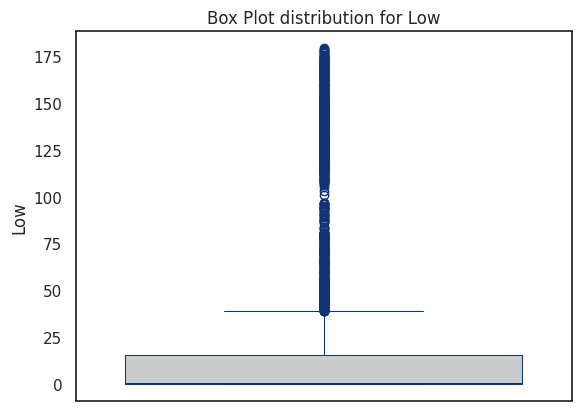

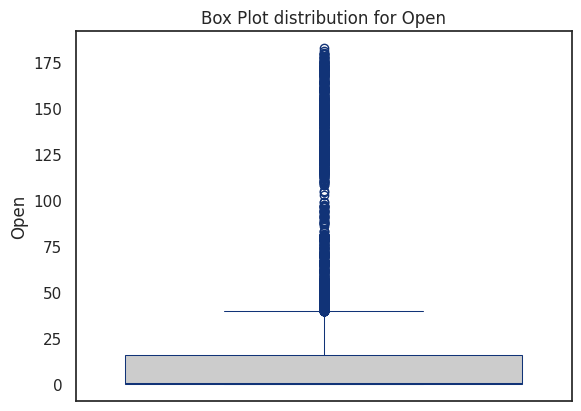

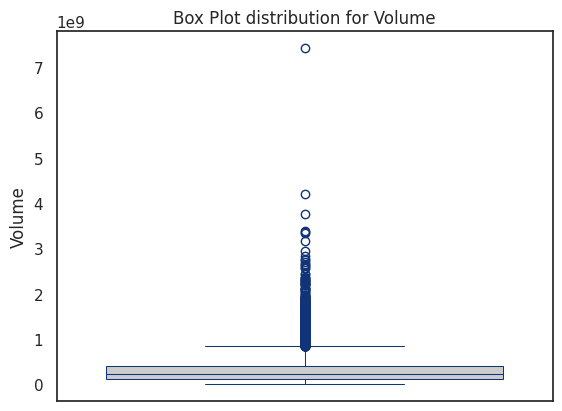

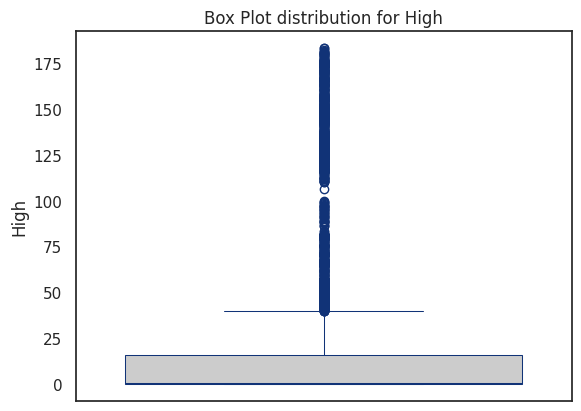

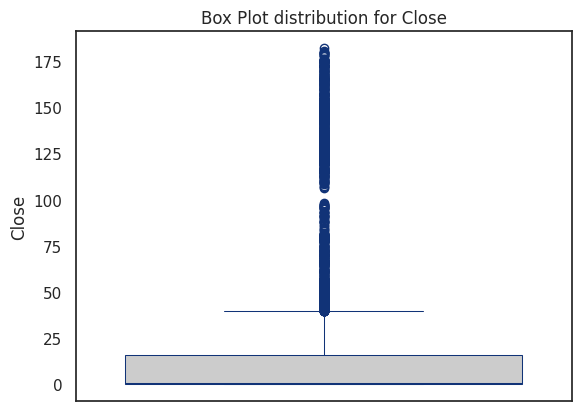

In [16]:
for var in db_Apple.columns:
        box_plot_single(db_Apple,var)

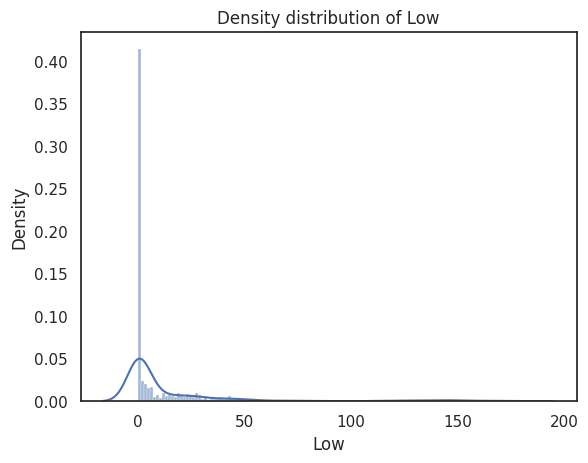

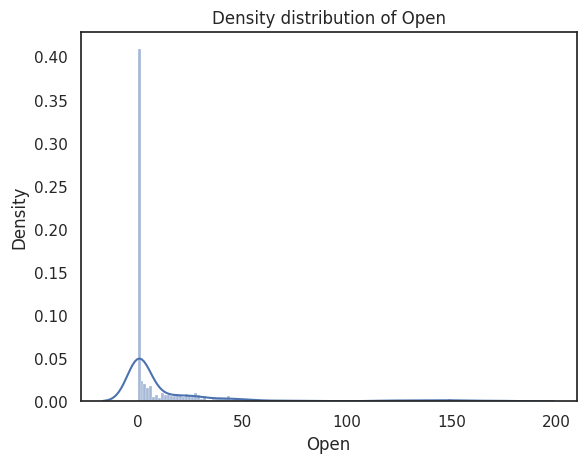

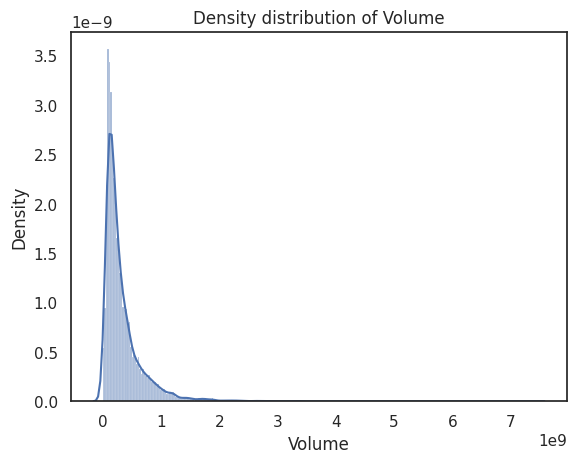

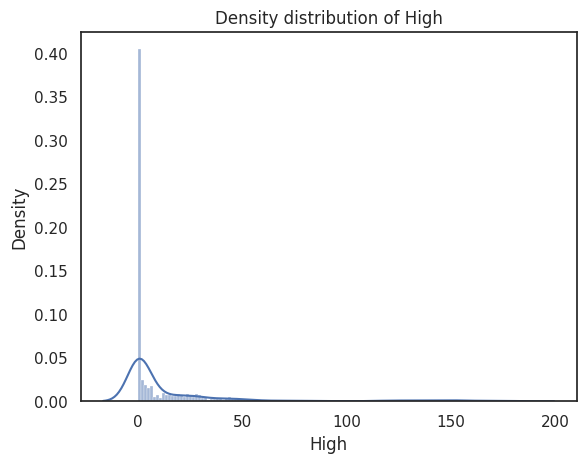

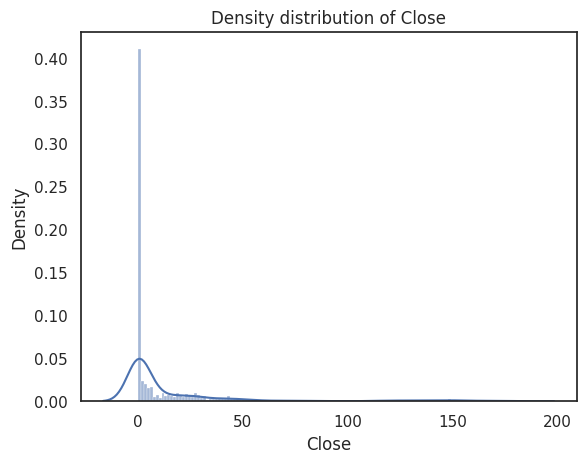

In [17]:
for var in db_Apple.columns:
        density_plot(db_Apple,var)

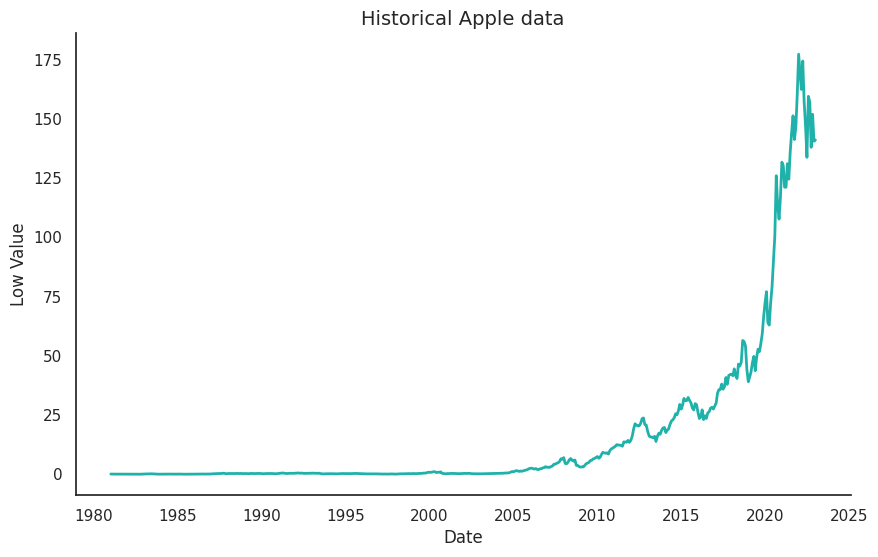

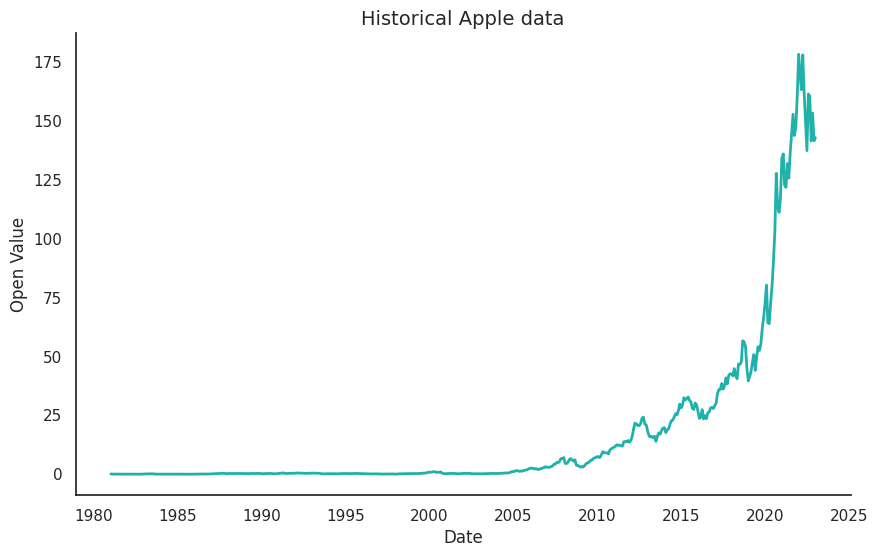

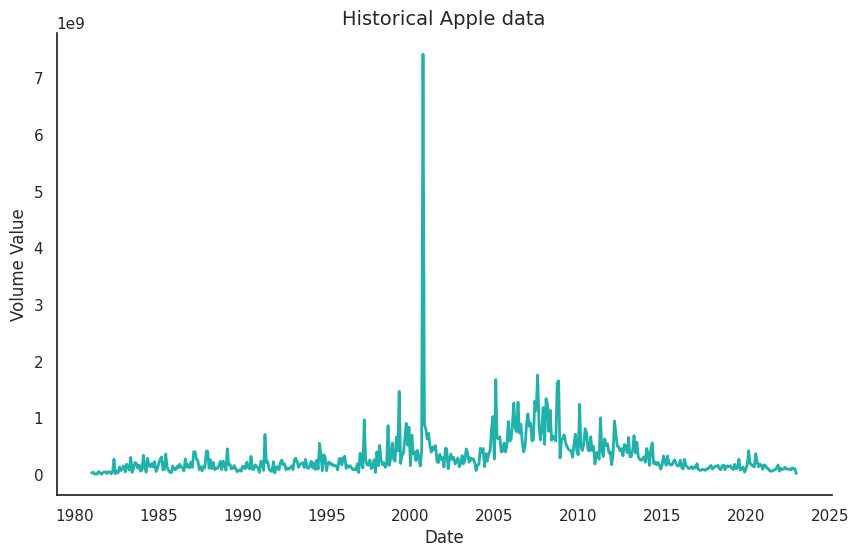

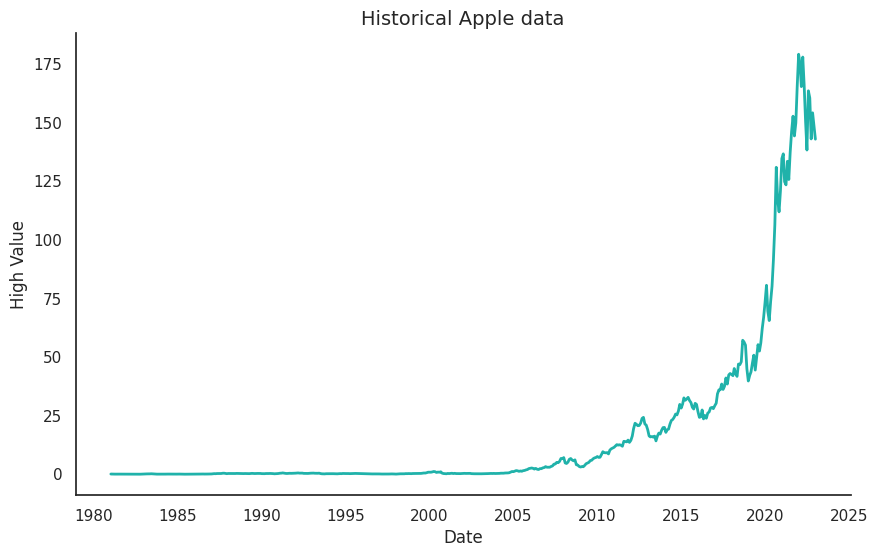

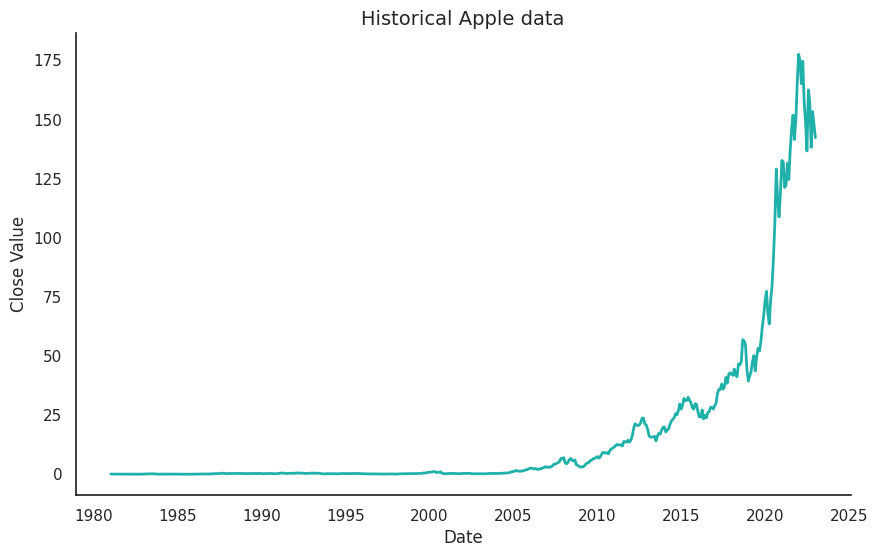

In [18]:
for var in db_Apple.columns:
        plot_index(db_Apple,var)

Data is sparse but the spread is strongly related to the time where the information is considered, which confirms values are related to most recent previous information

## Data Processing

### Data scaling - MinMax

In [19]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# DataFrame scaled
scaled_data = scaler.fit_transform(db_Apple)
db_Apple_scaled = pd.DataFrame(scaled_data, columns=db_Apple.columns).set_index(db_Apple.index)

for col in db_Apple_scaled.columns:
    print('Variable: ',col,';  min:', round(db_Apple_scaled[col].min(),10), '; max', round(db_Apple_scaled[col].max(),10))

#data was successfully scaled within range 0,1 considering whole sample
db_Apple_scaled.head(5)

Variable:  Low ;  min: 0.0 ; max 1.0
Variable:  Open ;  min: 0.0 ; max 1.0
Variable:  Volume ;  min: 0.0 ; max 1.0
Variable:  High ;  min: 0.0 ; max 1.0
Variable:  Close ;  min: 0.0 ; max 1.0


,Low,Open,Volume,High,Close
Date,,,,,
1980-12-12,0.000443,0.000431,0.063198,0.000433,0.000435
1980-12-15,0.000405,0.000397,0.023699,0.000397,0.000399
1980-12-16,0.000355,0.000348,0.014246,0.000348,0.000350
1980-12-17,0.000371,0.000361,0.011647,0.000363,0.000365
1980-12-18,0.000390,0.000379,0.009897,0.000381,0.000383


### Data split Train/Validation/Test

In [20]:
#Split data from old to most recent info using 80% for training, 10% for validation and 10% for testing
p_train, p_val, p_test = .8, .1, .1
t_size = db_Apple_scaled.shape[0]

#Create dataframes with sub-samples
df_train = db_Apple_scaled.iloc[0:int(t_size*p_train),:]
df_validation = db_Apple_scaled.iloc[int(t_size*p_train):int(t_size*(p_train+p_val)),:]
df_test = db_Apple_scaled.iloc[int(t_size*(p_train+p_val)):,:]

for db, name in [ (df_train,'Train'), (df_validation, 'Val'), (df_test, 'Test')]:
    print(f'For {name} Sample: \n - Min: {db.index.values[0]} Max: {db.index.values[-1]} Rows: {db.shape[0]} Prop: {round(db.shape[0]*100/t_size, 2)}%')

#Thus, data was successfully splitted

For Train Sample: 
 - Min: 1980-12-12T00:00:00.000000000 Max: 2014-07-16T00:00:00.000000000 Rows: 8472 Prop: 80.0%
For Val Sample: 
 - Min: 2014-07-17T00:00:00.000000000 Max: 2018-09-27T00:00:00.000000000 Rows: 1059 Prop: 10.0%
For Test Sample: 
 - Min: 2018-09-28T00:00:00.000000000 Max: 2022-12-12T00:00:00.000000000 Rows: 1059 Prop: 10.0%


## Modelling

### Stage 1

#### Initial settings

In [21]:
#### Build features to consider initial 60 obs of look_back (window)
look_back = 60

x_train, y_train = arrays_for_modelling(df_train,look_back)
x_validation, y_validation = arrays_for_modelling(df_validation,look_back)
x_test, y_test = arrays_for_modelling(df_test,look_back)

print('Size train sample: ', x_train.shape)
print('Size validation sample: ', x_validation.shape)
print('Size test sample: ', x_test.shape)

Size train sample:  (8412, 60, 5)
Size validation sample:  (999, 60, 5)
Size test sample:  (999, 60, 5)


In [22]:
# Initial settings
n_var = x_train.shape[2] #number of channels: 5 columns
seed = 41

# Hyperparameters
batch_size = 32
n_epochs = 20
loss_f = 'mean_squared_error'
lr = 0.001

model_results = pd.DataFrame()

The follwing model structures are based on the next examples:
* https://towardsdatascience.com/a-brief-introduction-to-recurrent-neural-networks-638f64a61ff4
* https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

#### Vanilla RNN model

Epoch 1/20
263/263 - 13s - loss: 0.0061 - val_loss: 0.0021 - 13s/epoch - 50ms/step
Epoch 2/20
263/263 - 10s - loss: 4.2802e-05 - val_loss: 0.0016 - 10s/epoch - 37ms/step
Epoch 3/20
263/263 - 9s - loss: 1.7068e-05 - val_loss: 0.0017 - 9s/epoch - 36ms/step
Epoch 4/20
263/263 - 9s - loss: 1.2096e-05 - val_loss: 0.0018 - 9s/epoch - 33ms/step
Epoch 5/20
263/263 - 10s - loss: 1.5009e-05 - val_loss: 0.0014 - 10s/epoch - 38ms/step
Epoch 6/20
263/263 - 10s - loss: 1.6130e-05 - val_loss: 0.0013 - 10s/epoch - 38ms/step
Epoch 7/20
263/263 - 10s - loss: 1.5716e-05 - val_loss: 0.0011 - 10s/epoch - 37ms/step
Epoch 8/20
263/263 - 10s - loss: 1.9665e-05 - val_loss: 9.3017e-04 - 10s/epoch - 39ms/step
Epoch 9/20
263/263 - 10s - loss: 2.7822e-05 - val_loss: 6.2820e-04 - 10s/epoch - 39ms/step
Epoch 10/20
263/263 - 10s - loss: 2.0332e-05 - val_loss: 0.0014 - 10s/epoch - 39ms/step
Epoch 11/20
263/263 - 10s - loss: 2.0691e-05 - val_loss: 9.1542e-04 - 10s/epoch - 40ms/step
Epoch 12/20
263/263 - 10s - loss: 4.0

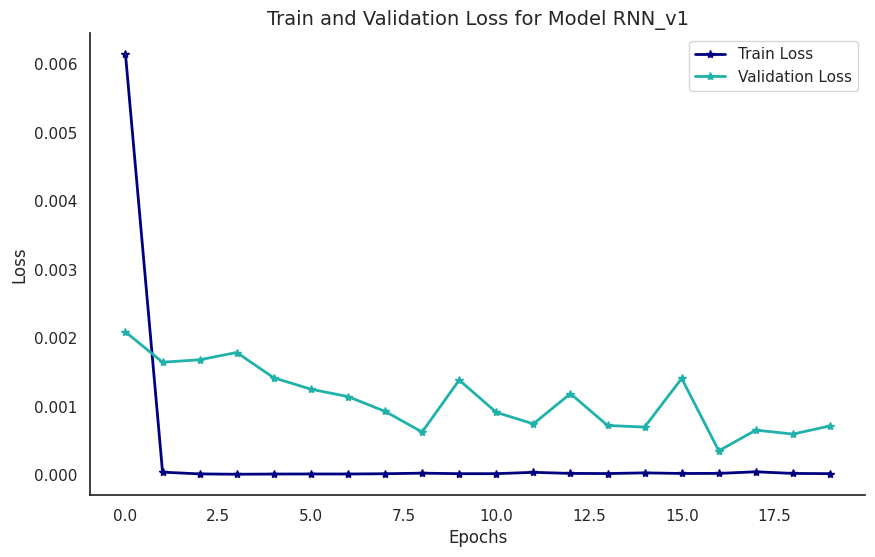

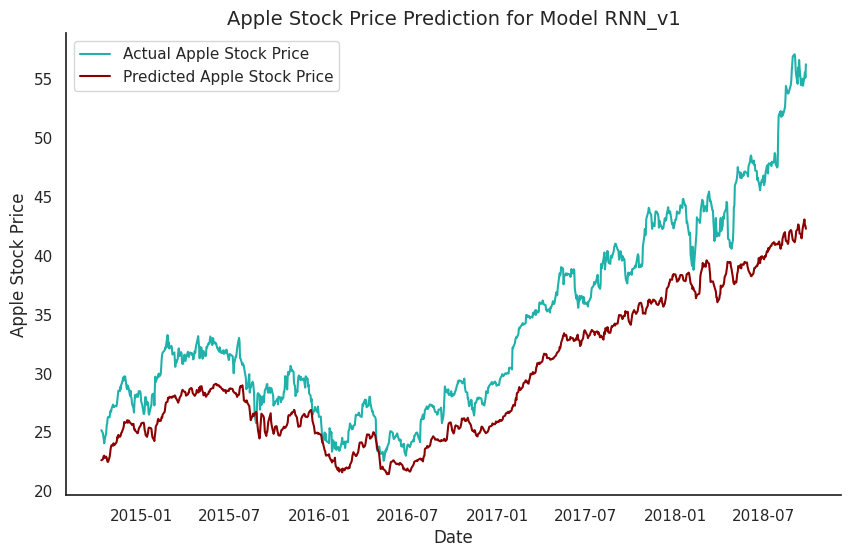

In [23]:
model_id = 'RNN_v1'

# Set seed to make results replicable
set_seed(seed)

# Define Sequencial RNN
model = Sequential() #Initialize RNN
model.add(Input(shape=(look_back, n_var)))  # Explicit Input layer

# Define layers
model.add(SimpleRNN(units=50, return_sequences=True)) #Layer 1, 50 neurons, default activation function tanh
model.add(SimpleRNN(units=50, return_sequences=True)) #Layer 2, 50 neurons, default activation function tanh
model.add(SimpleRNN(units=50, return_sequences=True)) #Layer 3, 50 neurons, default activation function tanh
model.add(SimpleRNN(units=50)) # Layer 4, 50 neurons, default activation function tanh
model.add(Dense(units = 1)) #FC layer

# Define optimizer and fit model to train sample
model.compile(loss = loss_f, optimizer = Adam(learning_rate = lr)) #Adam optimizer
history = model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data=(x_validation, y_validation), verbose = 2)

# Extract train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plot_lossess(train_loss, val_loss, model_id)

#Predict prices with model
y_hat_val_scaled = model.predict(x_validation, verbose = 0)
y_hat_val = inverse_transform_last_column(y_hat_val_scaled, scaler, n_var)
y_true_val = inverse_transform_last_column(y_validation, scaler, n_var)

#Plot predictions
X = df_validation.index.values[look_back:]
plot_pred(X, y_true_val, y_hat_val, model_id)

#save model results
model_results = pd.concat([model_results,
                           pd.DataFrame({'Model_ID':[model_id],'RMSE Train':train_loss[-1:],'RMSE Validation':val_loss[-1:]})],axis = 0)

# Save model
model.save(f'{model_id}.keras')

#### GRU model

Epoch 1/20
263/263 - 30s - loss: 3.1113e-05 - val_loss: 3.1309e-05 - 30s/epoch - 114ms/step
Epoch 2/20
263/263 - 22s - loss: 2.6878e-06 - val_loss: 5.6807e-05 - 22s/epoch - 84ms/step
Epoch 3/20
263/263 - 22s - loss: 2.9879e-06 - val_loss: 3.3111e-05 - 22s/epoch - 84ms/step
Epoch 4/20
263/263 - 22s - loss: 2.4499e-06 - val_loss: 2.5484e-05 - 22s/epoch - 84ms/step
Epoch 5/20
263/263 - 22s - loss: 3.0019e-06 - val_loss: 2.9227e-05 - 22s/epoch - 83ms/step
Epoch 6/20
263/263 - 22s - loss: 2.1891e-06 - val_loss: 2.6592e-05 - 22s/epoch - 83ms/step
Epoch 7/20
263/263 - 22s - loss: 2.3793e-06 - val_loss: 3.6184e-05 - 22s/epoch - 84ms/step
Epoch 8/20
263/263 - 21s - loss: 2.2757e-06 - val_loss: 2.6662e-05 - 21s/epoch - 79ms/step
Epoch 9/20
263/263 - 21s - loss: 2.5017e-06 - val_loss: 2.8440e-05 - 21s/epoch - 78ms/step
Epoch 10/20
263/263 - 21s - loss: 2.5604e-06 - val_loss: 2.2263e-05 - 21s/epoch - 80ms/step
Epoch 11/20
263/263 - 22s - loss: 1.6344e-06 - val_loss: 1.6346e-05 - 22s/epoch - 82ms/s

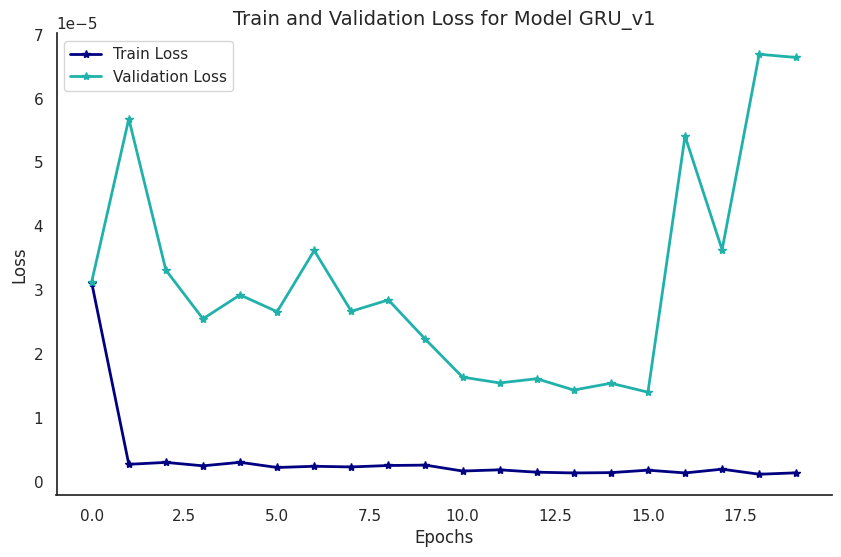

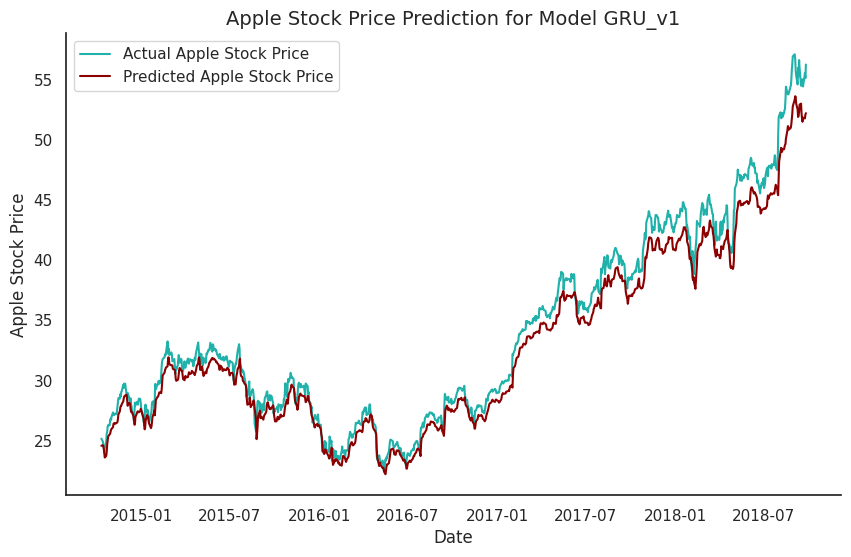

In [24]:
model_id = 'GRU_v1'

# Set seed to make results replicable
set_seed(seed)

# Define Sequencial RNN
model = Sequential() #Initialize RNN
model.add(Input(shape=(look_back, n_var)))  # Explicit Input layer

# Define layers
model.add(GRU(units=50, return_sequences=True)) #Layer 1, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(GRU(units=50, return_sequences=True)) #Layer 2, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(GRU(units=50, return_sequences=True)) #Layer 3, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(GRU(units=50)) # Layer 4, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(Dense(units = 1)) #FC layer

# Define optimizer and fit model to train sample
model.compile(loss = loss_f, optimizer = Adam(learning_rate = lr)) #Adam optimizer
history = model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data=(x_validation, y_validation), verbose = 2)

# Extract train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plot_lossess(train_loss, val_loss, model_id)

#Predict prices with model
y_hat_val_scaled = model.predict(x_validation, verbose = 0)
y_hat_val = inverse_transform_last_column(y_hat_val_scaled, scaler, n_var)
y_true_val = inverse_transform_last_column(y_validation, scaler, n_var)

#Plot predictions
X = df_validation.index.values[look_back:]
plot_pred(X, y_true_val, y_hat_val, model_id)

#save model results
model_results = pd.concat([model_results,
                           pd.DataFrame({'Model_ID':[model_id],'RMSE Train':train_loss[-1:],'RMSE Validation':val_loss[-1:]})],axis = 0)
# Save model
model.save(f'{model_id}.keras')

#### LSTM model

Epoch 1/20
263/263 - 27s - loss: 2.2106e-05 - val_loss: 1.2996e-04 - 27s/epoch - 103ms/step
Epoch 2/20
263/263 - 20s - loss: 5.8625e-06 - val_loss: 3.7246e-04 - 20s/epoch - 77ms/step
Epoch 3/20
263/263 - 20s - loss: 6.3011e-06 - val_loss: 2.1651e-04 - 20s/epoch - 75ms/step
Epoch 4/20
263/263 - 19s - loss: 4.9992e-06 - val_loss: 8.9450e-05 - 19s/epoch - 74ms/step
Epoch 5/20
263/263 - 18s - loss: 4.4335e-06 - val_loss: 9.1684e-05 - 18s/epoch - 69ms/step
Epoch 6/20
263/263 - 18s - loss: 3.6135e-06 - val_loss: 5.8620e-05 - 18s/epoch - 69ms/step
Epoch 7/20
263/263 - 18s - loss: 3.8522e-06 - val_loss: 6.5695e-05 - 18s/epoch - 70ms/step
Epoch 8/20
263/263 - 21s - loss: 3.6305e-06 - val_loss: 2.3854e-04 - 21s/epoch - 81ms/step
Epoch 9/20
263/263 - 19s - loss: 3.2763e-06 - val_loss: 5.3060e-05 - 19s/epoch - 71ms/step
Epoch 10/20
263/263 - 22s - loss: 3.6100e-06 - val_loss: 1.0491e-04 - 22s/epoch - 82ms/step
Epoch 11/20
263/263 - 21s - loss: 3.0551e-06 - val_loss: 4.2944e-05 - 21s/epoch - 79ms/s

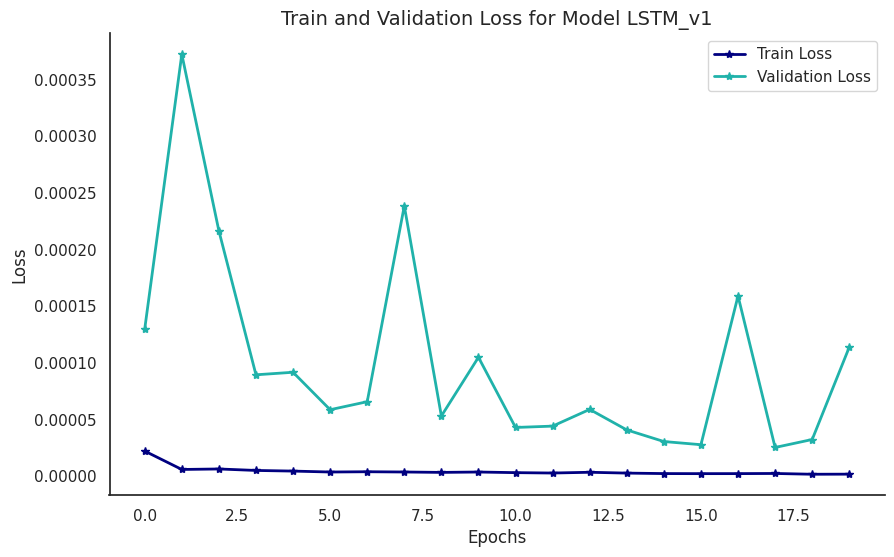

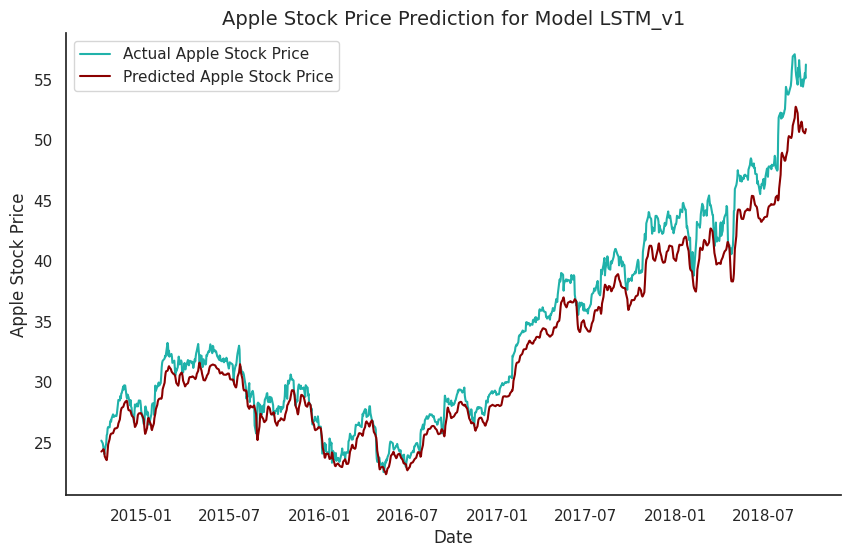

In [25]:
model_id = 'LSTM_v1'

# Set seed to make results replicable
set_seed(seed)

# Define Sequencial RNN
model = Sequential() #Initialize RNN
model.add(Input(shape=(look_back, n_var)))  # Explicit Input layer

# Define layers
model.add(LSTM(units=50, return_sequences=True)) #Layer 1, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(LSTM(units=50, return_sequences=True)) #Layer 2, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(LSTM(units=50, return_sequences=True)) #Layer 3, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(LSTM(units=50)) # Layer 4, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(Dense(units = 1)) #FC layer

# Define optimizer and fit model to train sample
model.compile(loss = loss_f, optimizer = Adam(learning_rate = lr)) #Adam optimizer
history = model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data=(x_validation, y_validation), verbose = 2)

# Extract train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plot_lossess(train_loss, val_loss, model_id)

#Predict prices with model
y_hat_val_scaled = model.predict(x_validation, verbose = 0)
y_hat_val = inverse_transform_last_column(y_hat_val_scaled, scaler, n_var)
y_true_val = inverse_transform_last_column(y_validation, scaler, n_var)

#Plot predictions
X = df_validation.index.values[look_back:]
plot_pred(X, y_true_val, y_hat_val, model_id)

#save model results
model_results = pd.concat([model_results,
                           pd.DataFrame({'Model_ID':[model_id],'RMSE Train':train_loss[-1:],'RMSE Validation':val_loss[-1:]})],axis = 0)
# Save model
model.save(f'{model_id}.keras')

### Stage 2

#### Settings

In [26]:
#### Build features to consider initial 30 obs of look_back (window)
look_back = 30

x_train, y_train = arrays_for_modelling(df_train,look_back)
x_validation, y_validation = arrays_for_modelling(df_validation,look_back)
x_test, y_test = arrays_for_modelling(df_test,look_back)

print('Size train sample: ', x_train.shape)
print('Size validation sample: ', x_validation.shape)
print('Size test sample: ', x_test.shape)

Size train sample:  (8442, 30, 5)
Size validation sample:  (1029, 30, 5)
Size test sample:  (1029, 30, 5)


#### Vanilla RNN model

Epoch 1/20
264/264 - 8s - loss: 0.0074 - val_loss: 0.0585 - 8s/epoch - 31ms/step
Epoch 2/20
264/264 - 5s - loss: 5.1847e-05 - val_loss: 0.0331 - 5s/epoch - 19ms/step
Epoch 3/20
264/264 - 5s - loss: 2.4434e-05 - val_loss: 0.0169 - 5s/epoch - 19ms/step
Epoch 4/20
264/264 - 5s - loss: 1.9350e-05 - val_loss: 0.0078 - 5s/epoch - 18ms/step
Epoch 5/20
264/264 - 5s - loss: 1.9240e-05 - val_loss: 0.0056 - 5s/epoch - 18ms/step
Epoch 6/20
264/264 - 5s - loss: 1.9159e-05 - val_loss: 0.0021 - 5s/epoch - 17ms/step
Epoch 7/20
264/264 - 5s - loss: 2.5771e-05 - val_loss: 9.7077e-04 - 5s/epoch - 19ms/step
Epoch 8/20
264/264 - 5s - loss: 2.8346e-05 - val_loss: 6.5133e-04 - 5s/epoch - 18ms/step
Epoch 9/20
264/264 - 5s - loss: 2.8860e-05 - val_loss: 4.9696e-04 - 5s/epoch - 18ms/step
Epoch 10/20
264/264 - 5s - loss: 3.2996e-05 - val_loss: 8.4943e-04 - 5s/epoch - 18ms/step
Epoch 11/20
264/264 - 4s - loss: 2.8381e-05 - val_loss: 5.3763e-04 - 4s/epoch - 17ms/step
Epoch 12/20
264/264 - 5s - loss: 3.8063e-05 - v

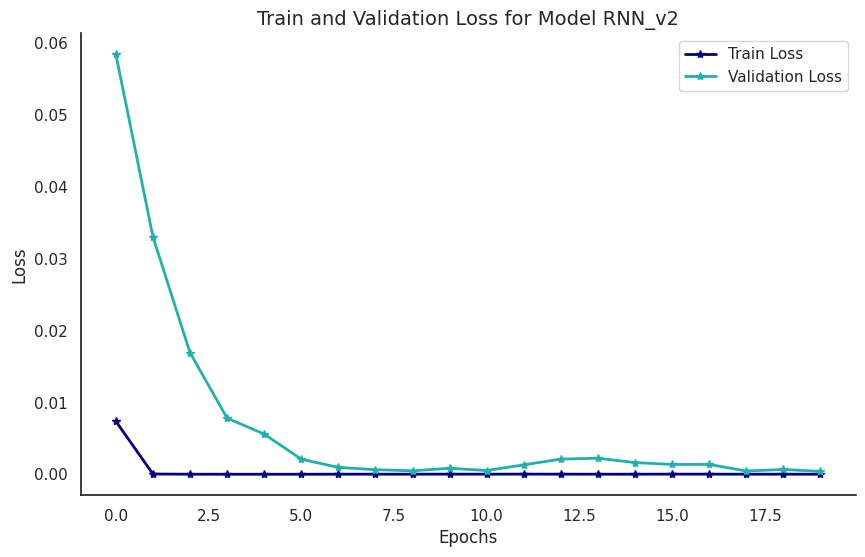

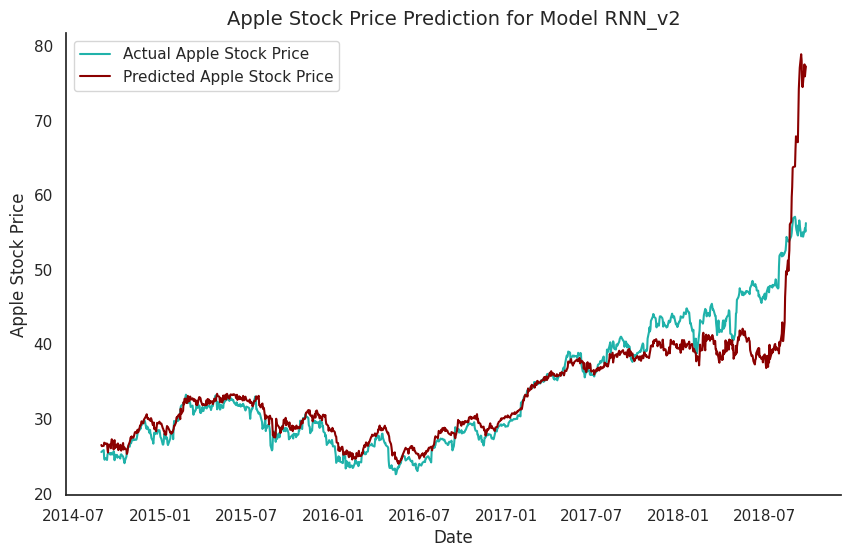

In [27]:
model_id = 'RNN_v2'

# Set seed to make results replicable
set_seed(seed)

# Define Sequencial RNN
model = Sequential() #Initialize RNN
model.add(Input(shape=(look_back, n_var)))  # Explicit Input layer

# Define layers
model.add(SimpleRNN(units=50, return_sequences=True)) #Layer 1, 50 neurons, default activation function tanh
model.add(SimpleRNN(units=50, return_sequences=True)) #Layer 2, 50 neurons, default activation function tanh
model.add(SimpleRNN(units=50, return_sequences=True)) #Layer 3, 50 neurons, default activation function tanh
model.add(SimpleRNN(units=50)) # Layer 4, 50 neurons, default activation function tanh
model.add(Dense(units = 1)) #FC layer

# Define optimizer and fit model to train sample
model.compile(loss = loss_f, optimizer = Adam(learning_rate = lr)) #Adam optimizer
history = model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data=(x_validation, y_validation), verbose = 2)

# Extract train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plot_lossess(train_loss, val_loss, model_id)

#Predict prices with model
y_hat_val_scaled = model.predict(x_validation, verbose = 0)
y_hat_val = inverse_transform_last_column(y_hat_val_scaled, scaler, n_var)
y_true_val = inverse_transform_last_column(y_validation, scaler, n_var)

#Plot predictions
X = df_validation.index.values[look_back:]
plot_pred(X, y_true_val, y_hat_val, model_id)

#save model results
model_results = pd.concat([model_results,
                           pd.DataFrame({'Model_ID':[model_id],'RMSE Train':train_loss[-1:],'RMSE Validation':val_loss[-1:]})],axis = 0)
# Save model
model.save(f'{model_id}.keras')

#### GRU model

Epoch 1/20
264/264 - 18s - loss: 1.9691e-05 - val_loss: 4.0353e-05 - 18s/epoch - 67ms/step
Epoch 2/20
264/264 - 9s - loss: 3.5808e-06 - val_loss: 3.4552e-05 - 9s/epoch - 34ms/step
Epoch 3/20
264/264 - 9s - loss: 2.6320e-06 - val_loss: 2.6378e-05 - 9s/epoch - 34ms/step
Epoch 4/20
264/264 - 10s - loss: 2.7673e-06 - val_loss: 3.1382e-04 - 10s/epoch - 38ms/step
Epoch 5/20
264/264 - 11s - loss: 2.6115e-06 - val_loss: 2.4791e-05 - 11s/epoch - 42ms/step
Epoch 6/20
264/264 - 10s - loss: 2.4774e-06 - val_loss: 2.4344e-05 - 10s/epoch - 40ms/step
Epoch 7/20
264/264 - 11s - loss: 2.2582e-06 - val_loss: 1.9239e-05 - 11s/epoch - 41ms/step
Epoch 8/20
264/264 - 11s - loss: 2.7363e-06 - val_loss: 2.0148e-05 - 11s/epoch - 42ms/step
Epoch 9/20
264/264 - 11s - loss: 1.9485e-06 - val_loss: 1.9750e-05 - 11s/epoch - 43ms/step
Epoch 10/20
264/264 - 11s - loss: 2.0081e-06 - val_loss: 1.6468e-05 - 11s/epoch - 42ms/step
Epoch 11/20
264/264 - 11s - loss: 1.9496e-06 - val_loss: 2.7640e-05 - 11s/epoch - 40ms/step
E

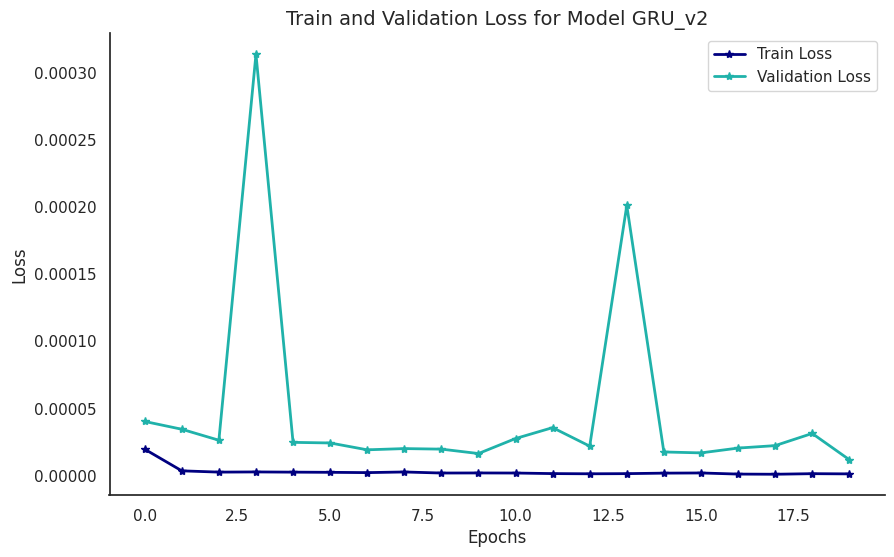

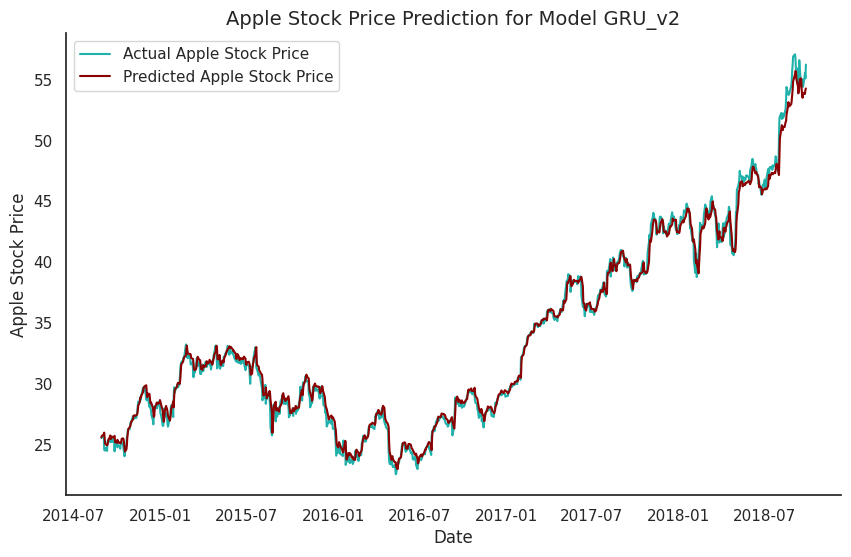

In [28]:
model_id = 'GRU_v2'

# Set seed to make results replicable
set_seed(seed)

# Define Sequencial RNN
model = Sequential() #Initialize RNN
model.add(Input(shape=(look_back, n_var)))  # Explicit Input layer

# Define layers
model.add(GRU(units=50, return_sequences=True)) #Layer 1, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(GRU(units=50, return_sequences=True)) #Layer 2, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(GRU(units=50, return_sequences=True)) #Layer 3, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(GRU(units=50)) # Layer 4, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(Dense(units = 1)) #FC layer

# Define optimizer and fit model to train sample
model.compile(loss = loss_f, optimizer = Adam(learning_rate = lr)) #Adam optimizer
history = model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data=(x_validation, y_validation), verbose = 2)

# Extract train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plot_lossess(train_loss, val_loss, model_id)

#Predict prices with model
y_hat_val_scaled = model.predict(x_validation, verbose = 0)
y_hat_val = inverse_transform_last_column(y_hat_val_scaled, scaler, n_var)
y_true_val = inverse_transform_last_column(y_validation, scaler, n_var)

#Plot predictions
X = df_validation.index.values[look_back:]
plot_pred(X, y_true_val, y_hat_val, model_id)

#save model results
model_results = pd.concat([model_results,
                           pd.DataFrame({'Model_ID':[model_id],'RMSE Train':train_loss[-1:],'RMSE Validation':val_loss[-1:]})],axis = 0)
# Save model
model.save(f'{model_id}.keras')

#### LSTM model

Epoch 1/20
264/264 - 17s - loss: 2.0930e-05 - val_loss: 1.7831e-04 - 17s/epoch - 65ms/step
Epoch 2/20
264/264 - 10s - loss: 6.1067e-06 - val_loss: 2.2964e-04 - 10s/epoch - 36ms/step
Epoch 3/20
264/264 - 11s - loss: 5.5804e-06 - val_loss: 9.3657e-05 - 11s/epoch - 40ms/step
Epoch 4/20
264/264 - 11s - loss: 4.9141e-06 - val_loss: 4.0690e-04 - 11s/epoch - 42ms/step
Epoch 5/20
264/264 - 10s - loss: 4.7143e-06 - val_loss: 1.7005e-04 - 10s/epoch - 38ms/step
Epoch 6/20
264/264 - 10s - loss: 4.3702e-06 - val_loss: 6.6849e-05 - 10s/epoch - 36ms/step
Epoch 7/20
264/264 - 10s - loss: 4.3253e-06 - val_loss: 7.8413e-05 - 10s/epoch - 40ms/step
Epoch 8/20
264/264 - 11s - loss: 3.5935e-06 - val_loss: 6.2642e-05 - 11s/epoch - 40ms/step
Epoch 9/20
264/264 - 11s - loss: 3.7406e-06 - val_loss: 5.2257e-05 - 11s/epoch - 41ms/step
Epoch 10/20
264/264 - 11s - loss: 3.4661e-06 - val_loss: 6.2263e-05 - 11s/epoch - 40ms/step
Epoch 11/20
264/264 - 11s - loss: 2.6381e-06 - val_loss: 4.2034e-05 - 11s/epoch - 42ms/st

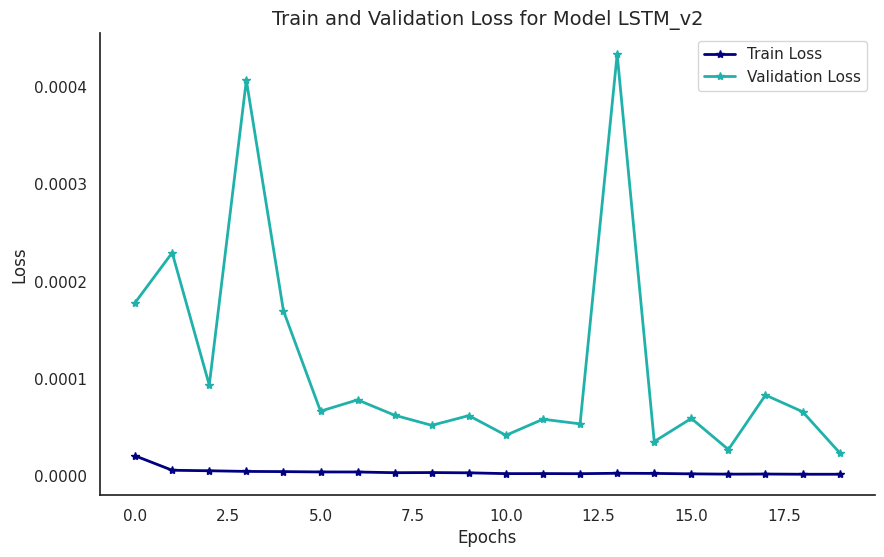

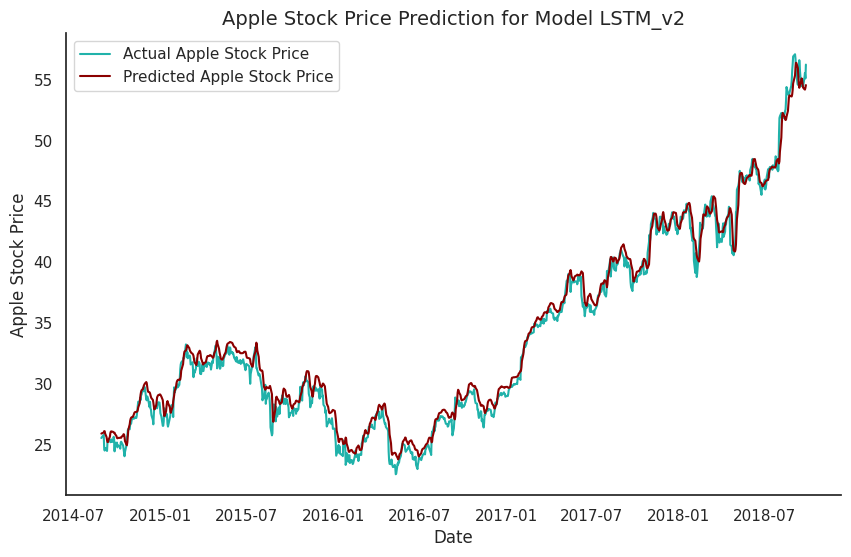

In [29]:
model_id = 'LSTM_v2'

# Set seed to make results replicable
set_seed(seed)

# Define Sequencial RNN
model = Sequential() #Initialize RNN
model.add(Input(shape=(look_back, n_var)))  # Explicit Input layer

# Define layers
model.add(LSTM(units=50, return_sequences=True)) #Layer 1, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(LSTM(units=50, return_sequences=True)) #Layer 2, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(LSTM(units=50, return_sequences=True)) #Layer 3, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(LSTM(units=50)) # Layer 4, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(Dense(units = 1)) #FC layer

# Define optimizer and fit model to train sample
model.compile(loss = loss_f, optimizer = Adam(learning_rate = lr)) #Adam optimizer
history = model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data=(x_validation, y_validation), verbose = 2)

# Extract train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plot_lossess(train_loss, val_loss, model_id)

#Predict prices with model
y_hat_val_scaled = model.predict(x_validation, verbose = 0)
y_hat_val = inverse_transform_last_column(y_hat_val_scaled, scaler, n_var)
y_true_val = inverse_transform_last_column(y_validation, scaler, n_var)

#Plot predictions
X = df_validation.index.values[look_back:]
plot_pred(X, y_true_val, y_hat_val, model_id)

#save model results
model_results = pd.concat([model_results,
                           pd.DataFrame({'Model_ID':[model_id],'RMSE Train':train_loss[-1:],'RMSE Validation':val_loss[-1:]})],axis = 0)
# Save model
model.save(f'{model_id}.keras')

### Stage 3

In [30]:
lr = 0.0001

#### GRU Model

Epoch 1/20
264/264 - 26s - loss: 1.3515e-04 - val_loss: 9.1995e-05 - 26s/epoch - 98ms/step
Epoch 2/20
264/264 - 15s - loss: 2.0634e-05 - val_loss: 7.0114e-05 - 15s/epoch - 58ms/step
Epoch 3/20
264/264 - 16s - loss: 1.7878e-05 - val_loss: 6.0508e-05 - 16s/epoch - 62ms/step
Epoch 4/20
264/264 - 16s - loss: 1.6033e-05 - val_loss: 7.5782e-05 - 16s/epoch - 61ms/step
Epoch 5/20
264/264 - 17s - loss: 1.4251e-05 - val_loss: 5.2123e-05 - 17s/epoch - 63ms/step
Epoch 6/20
264/264 - 16s - loss: 1.4021e-05 - val_loss: 9.3866e-05 - 16s/epoch - 62ms/step
Epoch 7/20
264/264 - 17s - loss: 1.2138e-05 - val_loss: 5.1370e-05 - 17s/epoch - 64ms/step
Epoch 8/20
264/264 - 16s - loss: 1.3430e-05 - val_loss: 4.8555e-05 - 16s/epoch - 59ms/step
Epoch 9/20
264/264 - 17s - loss: 1.2732e-05 - val_loss: 5.0224e-05 - 17s/epoch - 64ms/step
Epoch 10/20
264/264 - 16s - loss: 1.2218e-05 - val_loss: 4.8477e-05 - 16s/epoch - 61ms/step
Epoch 11/20
264/264 - 14s - loss: 1.1700e-05 - val_loss: 9.5879e-05 - 14s/epoch - 53ms/st

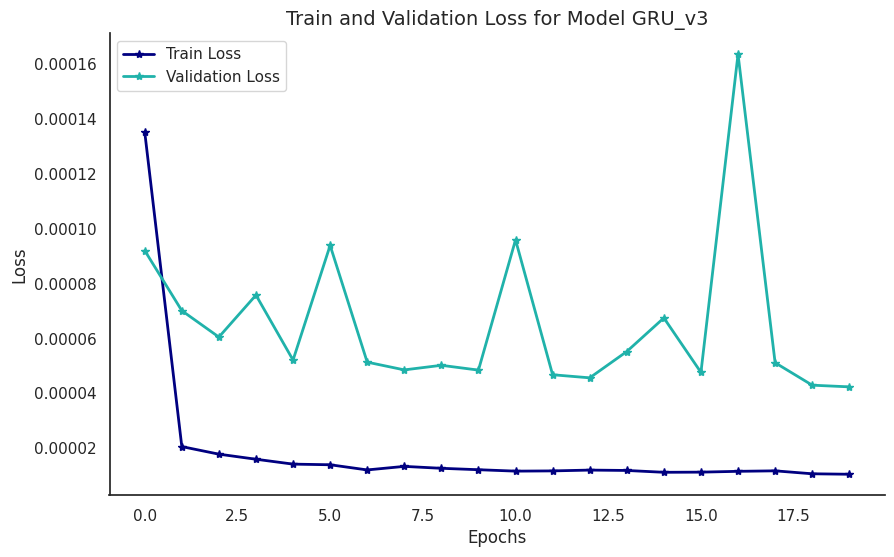

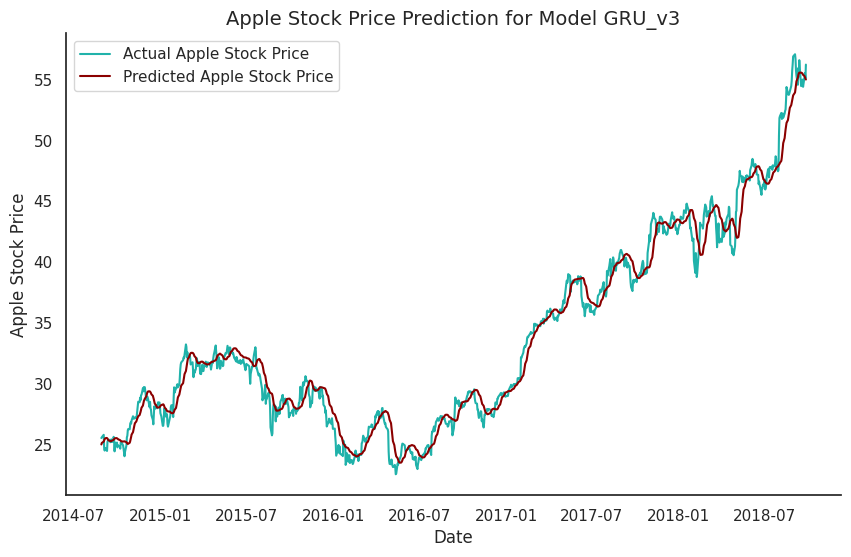

In [31]:
model_id = 'GRU_v3'

# Set seed to make results replicable
set_seed(seed)

# Define Sequencial RNN
model = Sequential() #Initialize RNN
model.add(Input(shape=(look_back, n_var)))  # Explicit Input layer

# Define layers
model.add(GRU(units=50, return_sequences=True)) #Layer 1, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(GRU(units=50, return_sequences=True)) #Layer 2, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(GRU(units=50, return_sequences=True)) #Layer 3, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)
model.add(GRU(units=50, return_sequences=True)) #Layer 4, 50 neurons, default tanh for hidden state and sigmoid for gates (update and reset)

model.add(GRU(units=50, return_sequences=True)) #Layer 5  New layer included
model.add(Dropout(0.20)) #Dropout added
model.add(GRU(units=50)) #Layer 6  New layer included
model.add(Dropout(0.20)) #Dropout added

model.add(Dense(units = 1)) #FC layer

# Define optimizer and fit model to train sample
model.compile(loss = loss_f, optimizer = Adam(learning_rate = lr)) #Adam optimizer
history = model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data=(x_validation, y_validation), verbose = 2)

# Extract train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plot_lossess(train_loss, val_loss, model_id)

#Predict prices with model
y_hat_val_scaled = model.predict(x_validation, verbose = 0)
y_hat_val = inverse_transform_last_column(y_hat_val_scaled, scaler, n_var)
y_true_val = inverse_transform_last_column(y_validation, scaler, n_var)

#Plot predictions
X = df_validation.index.values[look_back:]
plot_pred(X, y_true_val, y_hat_val, model_id)

#save model results
model_results = pd.concat([model_results,
                           pd.DataFrame({'Model_ID':[model_id],'RMSE Train':train_loss[-1:],'RMSE Validation':val_loss[-1:]})],axis = 0)
# Save model
model.save(f'{model_id}.keras')

#### LSTM Model

Epoch 1/20
264/264 - 27s - loss: 1.0224e-04 - val_loss: 4.3325e-04 - 27s/epoch - 102ms/step
Epoch 2/20
264/264 - 16s - loss: 2.0660e-05 - val_loss: 2.3420e-04 - 16s/epoch - 60ms/step
Epoch 3/20
264/264 - 16s - loss: 1.8103e-05 - val_loss: 2.5630e-04 - 16s/epoch - 62ms/step
Epoch 4/20
264/264 - 14s - loss: 1.7233e-05 - val_loss: 1.5549e-04 - 14s/epoch - 55ms/step
Epoch 5/20
264/264 - 14s - loss: 1.5731e-05 - val_loss: 1.9938e-04 - 14s/epoch - 54ms/step
Epoch 6/20
264/264 - 14s - loss: 1.6260e-05 - val_loss: 5.3495e-04 - 14s/epoch - 54ms/step
Epoch 7/20
264/264 - 15s - loss: 1.4537e-05 - val_loss: 3.0217e-04 - 15s/epoch - 56ms/step
Epoch 8/20
264/264 - 14s - loss: 1.6520e-05 - val_loss: 2.7420e-04 - 14s/epoch - 54ms/step
Epoch 9/20
264/264 - 16s - loss: 1.5084e-05 - val_loss: 2.4208e-04 - 16s/epoch - 59ms/step
Epoch 10/20
264/264 - 17s - loss: 1.4512e-05 - val_loss: 2.2788e-04 - 17s/epoch - 63ms/step
Epoch 11/20
264/264 - 15s - loss: 1.3853e-05 - val_loss: 5.7278e-04 - 15s/epoch - 58ms/s

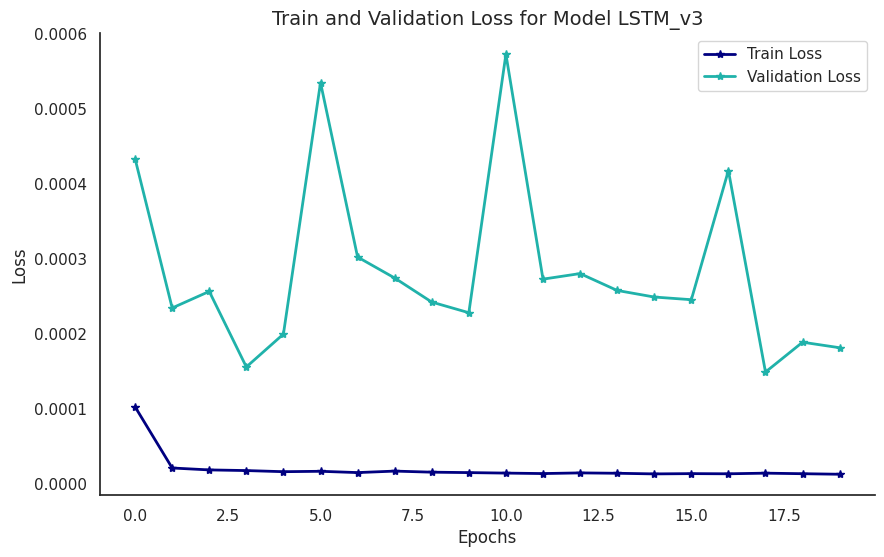

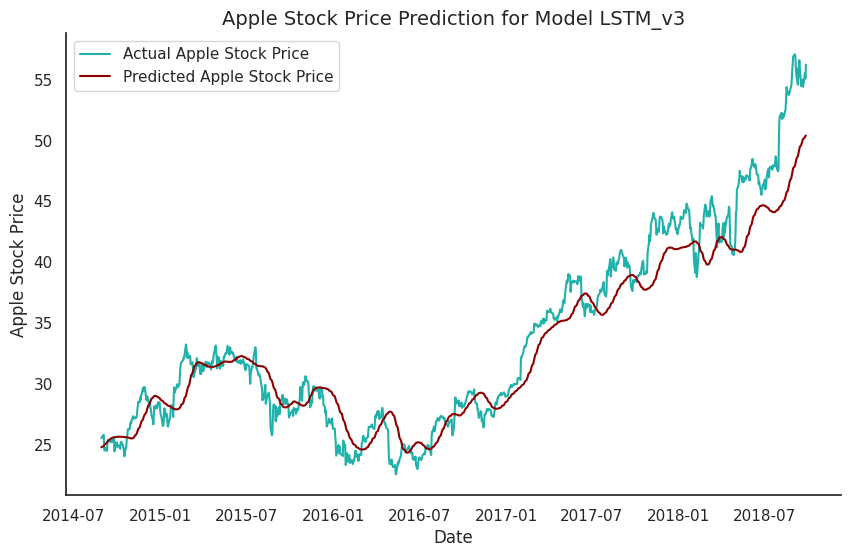

In [32]:
model_id = 'LSTM_v3'

# Set seed to make results replicable
set_seed(seed)

# Define Sequencial RNN
model = Sequential() #Initialize RNN
model.add(Input(shape=(look_back, n_var)))  # Explicit Input layer

# Define layers
model.add(LSTM(units=50, return_sequences=True)) #Layer 1, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(LSTM(units=50, return_sequences=True)) #Layer 2, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(LSTM(units=50, return_sequences=True)) #Layer 3, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)
model.add(LSTM(units=50, return_sequences=True)) #Layer 4, 50 neurons, default tanh for cell state and sigmoid for gates (input, forget, output)

model.add(LSTM(units=50, return_sequences=True)) #Layer 5  New layer included
model.add(Dropout(0.20)) #Dropout added
model.add(LSTM(units=50)) #Layer 6  New layer included
model.add(Dropout(0.20)) #Dropout added

model.add(Dense(units = 1)) #FC layer

# Define optimizer and fit model to train sample
model.compile(loss = loss_f, optimizer = Adam(learning_rate = lr)) #Adam optimizer
history = model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, validation_data=(x_validation, y_validation), verbose = 2)

# Extract train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the losses
plot_lossess(train_loss, val_loss, model_id)

#Predict prices with model
y_hat_val_scaled = model.predict(x_validation, verbose = 0)
y_hat_val = inverse_transform_last_column(y_hat_val_scaled, scaler, n_var)
y_true_val = inverse_transform_last_column(y_validation, scaler, n_var)

#Plot predictions
X = df_validation.index.values[look_back:]
plot_pred(X, y_true_val, y_hat_val, model_id)

#save model results
model_results = pd.concat([model_results,
                           pd.DataFrame({'Model_ID':[model_id],'RMSE Train':train_loss[-1:],'RMSE Validation':val_loss[-1:]})],axis = 0)
# Save model
model.save(f'{model_id}.keras')

In [33]:
model_results

,Model_ID,RMSE Train,RMSE Validation
0,RNN_v1,0.000021,0.000718
0,GRU_v1,0.000001,0.000066
0,LSTM_v1,0.000002,0.000114
0,RNN_v2,0.000024,0.000416
0,GRU_v2,0.000001,0.000012
0,LSTM_v2,0.000002,0.000024
0,GRU_v3,0.000011,0.000042
0,LSTM_v3,0.000012,0.000181


The columns say RMSE but acctually was was computed is just the MSE. The correct loss function will be reported in the document properly

In [40]:
#Save results for further analysis
model_results.to_csv('model_results.csv', index=False)

#### Last predictions in Test Sample with final candidate GRU_v2

MSE test sample:  0.09635244094981586


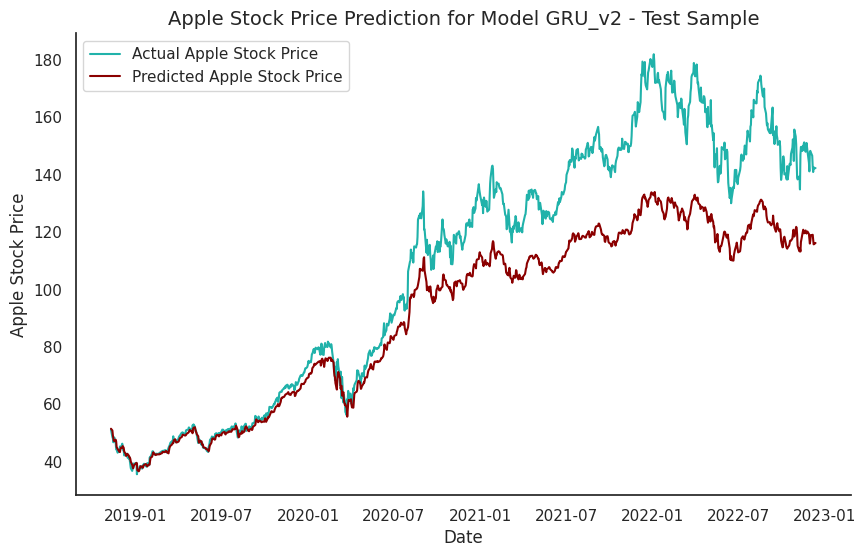

In [35]:
model_id = 'GRU_v2'

# Load the entire model
model = load_model(f'{model_id}.keras',  compile=False)

#Predict prices with Test sample
y_hat_test_scaled = model.predict(x_test, verbose = 0)
mse_test = np.mean((y_test - y_hat_test_scaled) ** 2)
print('MSE test sample: ', mse_test)

y_hat_test = inverse_transform_last_column(y_hat_test_scaled, scaler, n_var)
y_true_test = inverse_transform_last_column(y_test, scaler, n_var)

#Plot predictions
X = df_test.index.values[look_back:]
plot_pred(X, y_true_test, y_hat_test, model_id+' - Test Sample')

MSE test sample:  0.09653542753363067


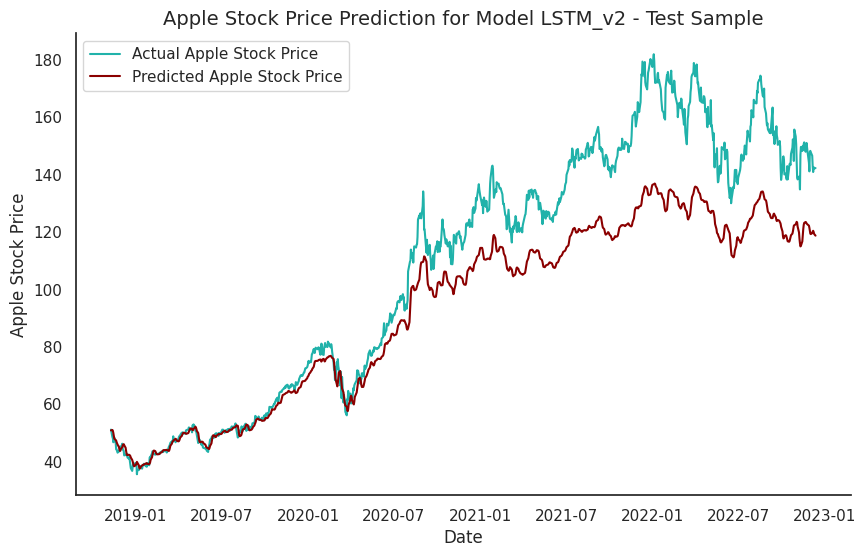

In [36]:
model_id = 'LSTM_v2'

# Load the entire model
model = load_model(f'{model_id}.keras',  compile=False)

#Predict prices with Test sample
y_hat_test_scaled = model.predict(x_test, verbose = 0)
mse_test = np.mean((y_test - y_hat_test_scaled) ** 2)
print('MSE test sample: ', mse_test)

y_hat_test = inverse_transform_last_column(y_hat_test_scaled, scaler, n_var)
y_true_test = inverse_transform_last_column(y_test, scaler, n_var)

#Plot predictions
X = df_test.index.values[look_back:]
plot_pred(X, y_true_test, y_hat_test, model_id+' - Test Sample')

## Download final results

In [39]:
#Download models, outpus and plots
for model in model_results['Model_ID']:
    files.download(f"Time_losses_{model}.png")
    files.download(f"Time_pred_{model}.png")
    #files.download(f"{model}.KERAS")

files.download(f"Time_series_Close.png")
files.download(f"Time_pred_GRU_v2 - Test Sample.png")
files.download(f"Time_pred_LSTM_v2 - Test Sample.png")

files.download('model_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Document plots

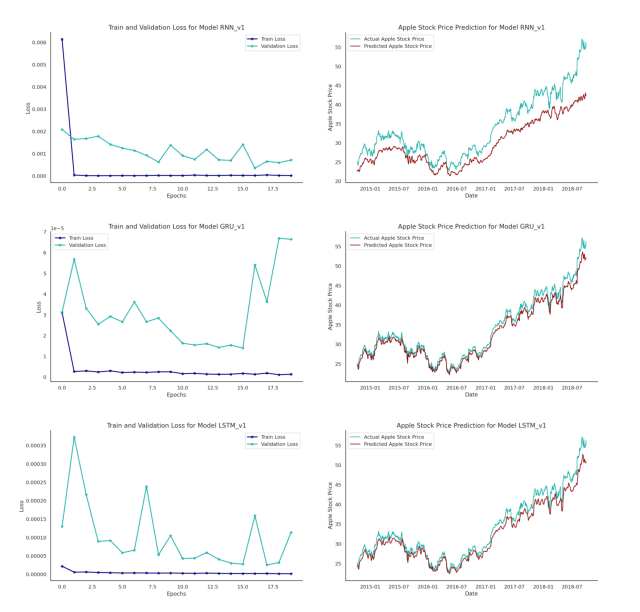

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the folder containing the images
folder_path = "Output files"
images_names = ["Time_losses_RNN_v1.png","Time_pred_RNN_v1.png", 
                "Time_losses_GRU_v1.png", "Time_pred_GRU_v1.png",
                "Time_losses_LSTM_v1.png", "Time_pred_LSTM_v1.png"
               ]
image_paths = [os.path.join(folder_path, image) for image in images_names]

images = [Image.open(img_path) for img_path in image_paths]

# Create grid
fig, axes = plt.subplots(3, 2, figsize=(8, 8))

# Display each image in the grid
for ax, img in zip(axes.flatten(), images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Show the grid
plt.subplots_adjust(wspace= -.09, hspace= -.09)
plt.savefig("Plots_stage1.png",dpi=200)
plt.show()

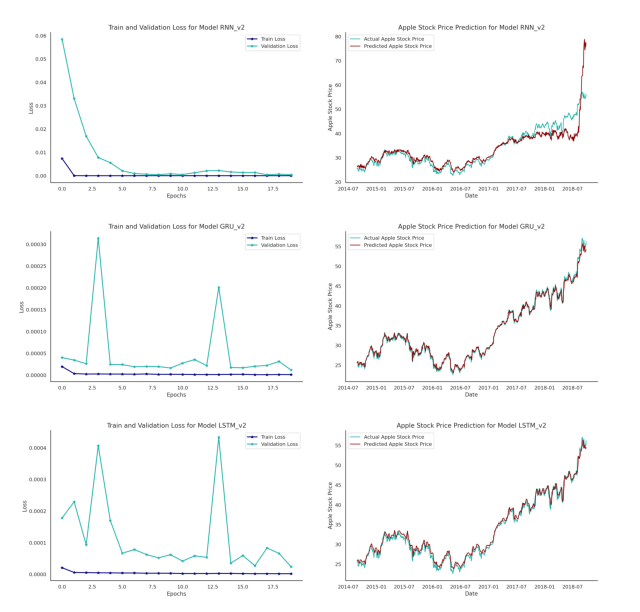

In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the folder containing the images
folder_path = "Output files"
images_names = ["Time_losses_RNN_v2.png","Time_pred_RNN_v2.png", 
                "Time_losses_GRU_v2.png", "Time_pred_GRU_v2.png",
                "Time_losses_LSTM_v2.png", "Time_pred_LSTM_v2.png"
               ]
image_paths = [os.path.join(folder_path, image) for image in images_names]

images = [Image.open(img_path) for img_path in image_paths]

# Create grid
fig, axes = plt.subplots(3, 2, figsize=(8, 8))

# Display each image in the grid
for ax, img in zip(axes.flatten(), images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Show the grid
plt.subplots_adjust(wspace= -.09, hspace= -.09)
plt.savefig("Plots_stage2.png",dpi=200)
plt.show()

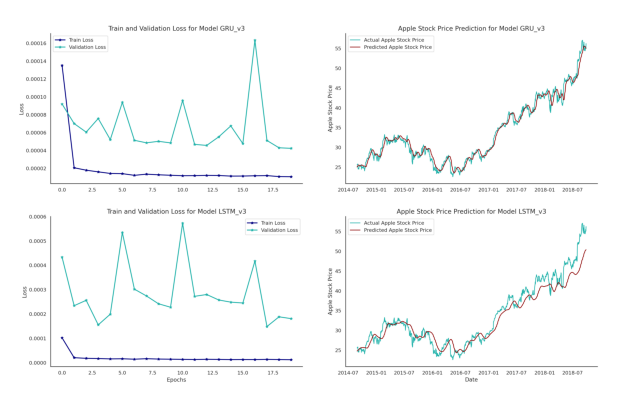

In [22]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the folder containing the images
folder_path = "Output files"
images_names = [ 
                "Time_losses_GRU_v3.png", "Time_pred_GRU_v3.png",
                "Time_losses_LSTM_v3.png", "Time_pred_LSTM_v3.png"
               ]
image_paths = [os.path.join(folder_path, image) for image in images_names]

images = [Image.open(img_path) for img_path in image_paths]

# Create grid
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# Display each image in the grid
for ax, img in zip(axes.flatten(), images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Show the grid
plt.subplots_adjust(wspace= -.09, hspace= -.09)
plt.savefig("Plots_stage3.png",dpi=200)
plt.show()

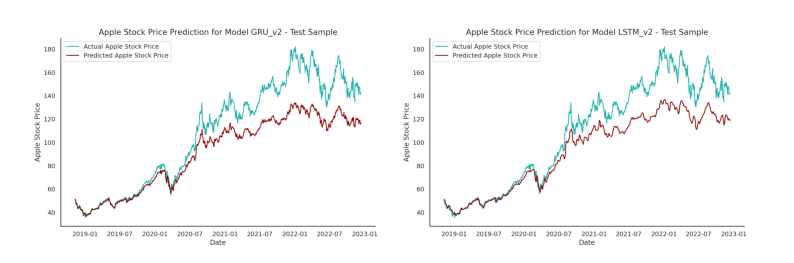

In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define the folder containing the images
folder_path = "Output files"
images_names = [ 
                "Time_pred_GRU_v2 - Test Sample.png", "Time_pred_LSTM_v2 - Test Sample.png",
               ]
image_paths = [os.path.join(folder_path, image) for image in images_names]

images = [Image.open(img_path) for img_path in image_paths]

# Create grid
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display each image in the grid
for ax, img in zip(axes.flatten(), images):
    ax.imshow(img)
    ax.axis('off')  # Hide axes

# Show the grid
plt.subplots_adjust(wspace= -.09, hspace= -.09)
plt.savefig("Plots_test_sample.png",dpi=200)
plt.show()